<a href="https://colab.research.google.com/github/shubhamscifi/Instacart-Market-Basket-Analysis/blob/main/7.%20More%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/)**

---
- Given order_id predict all the products that the user will reorder.

---








## Importing libraries

In [ ]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
# https://pypi.org/project/tqdm/#:~:text=jupyter%20console.%20Use-,auto,-instead%20of%20autonotebook
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split

bold = lambda string: '\033[1m'+string+'\033[0m'    # for bold text
printb = lambda string: print('\033[1m'+string+'\033[0m')
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

## Kaggle file uploader utility:
- To upload intermediate tables.

In [ ]:
def kaggle_file_uploader(files,id='shubhamscifi/instacart',title='instacart',folder='data',msg='',first_time=False,del_after_upload=True):
    '''Uploads list of files to kaggle.
    Note: make sure to run after kaggle authentication.
    id : must be between 6-50 chars after "username/".
    title : must be between 6-50 chars.
    files : list of path of files that are to be uploaded.
    first_time: True if the data is being uploaded for the first time.
    del_after_upload: True if given folder needs to be deleted after file upload finishes.'''
    # https://github.com/Kaggle/kaggle-api

    # create data package json file
    !mkdir {folder}
    !kaggle datasets init -p {folder}

    # preparing metadata json file
    import json,os
    metadata = open(os.path.join(folder,'dataset-metadata.json'),'r+')
    meta = json.load(metadata)
    meta['id'] = id
    meta['title']= title
    metadata.seek(0)
    json.dump(meta,metadata)
    metadata.truncate()
    metadata.close()

    for file in set(files):
        !cp {file} {folder}

    # upload dataset to kaggle
    if (first_time):
        !kaggle datasets create -p {folder}
    else:
        # Create a New Dataset Version
        !kaggle datasets version -p {folder} -m '{msg}'

    if (del_after_upload):
        !rm -rf {folder}

## Loading Data

In [ ]:
# Kaggle authentication
from getpass import getpass
import os

os.environ['KAGGLE_USERNAME'] = "shubhamscifi" #input('Enter kaggle username: ') # kaggle username
os.environ['KAGGLE_KEY'] = getpass('Enter Token: ') # kaggle api key

Enter Token: ··········


**Download intermediate prepared tables.**

In [ ]:
!kaggle datasets download -d shubhamscifi/instacart --unzip

 99% 1.46G/1.47G [00:13<00:00, 189MB/s]
100% 1.47G/1.47G [00:13<00:00, 113MB/s]


In [ ]:
%%time
dataset = pd.read_feather('dataset.feather')

CPU times: user 2.92 s, sys: 19.8 s, total: 22.7 s
Wall time: 1.35 s


In [ ]:
# loading data into pandas dataframe
orders = pd.read_csv('/content/orders.csv',dtype={'order_id':np.uint32,
                                                  'user_id' :np.uint32,
                                                  'order_number':'uint8',
                                                  'order_hour_of_day':'uint8',
                                                  'order_dow':'uint8',
                                                  'days_since_prior_order':'float16'})
dep = pd.read_csv('/content/departments.csv', dtype={'department_id':'uint8',
                                                     'department': str})
aisles = pd.read_csv('/content/aisles.csv', dtype={'aisle_id':'uint8',
                                                     'aisle': str})
products = pd.read_csv('/content/products.csv', dtype={'aisle_id':'uint8',
                                                     'department_id':'uint8',
                                                     'product_name': str,
                                                     'product_id': np.uint16})
order_products_prior = pd.read_csv('/content/order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('/content/order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

## Merging Tables.

In [ ]:
# Merging relational tables
# joining orders and order_products_prior table to get whole prior data table.
prior_data = orders.merge(order_products_prior, how='inner', on='order_id')

# sorting prior_data to get a more structured data so that we can analyse well.
prior_data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
prior_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [ ]:
prod_info = products.merge(dep,on='department_id').merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables




---



## More feature Engineering

- **order_number:** order number of the future order of user.
- **days_since_prior_order:** days_since_prior_order of the future order of user.
- **avg_#reorders_hour:** Avg of no. of reorders of all prior orders at a given hour.
- **p(reorder|hour_of_day):** (Total no. of reorders)/(Total no. of purchases) at a given hour.
- **avg_#reorders_dow:** Avg of no. of reorders of all prior orders at a given day of week.
- **p(reorder|dow):** (Total no. of reorders)/(Total no. of purchases) at a given day of week.
- **avg_#reorders_order_number:** Avg of no. of reorders of all prior orders at a given order_number.
- **p(reorder|order_number):** (Total no. of reorders)/(Total no. of purchases) at a given order_number.
- **#orders_u:** Total no. of prior orders placed by the user.
- **avg_#reorders_dspo:** Avg of no. of reorders of all prior orders at a given days_since_prior_order.
- **p(reorder|dspo):** (Total no. of reorders)/(Total no. of purchases) at a given days_since_prior_order.
- **is_weekly_user:** Is the user a weekly user.
- **is_monthly_user:** Is the user a monthly user.
- **Median_lifetime_days_gap_up:** Median no. of days gap after which the user purchases the product again.
- **Max_lifetime_days_gap_up:** Max no. of days gap after which the user purchases the product again.
- **Median_lifetime_orders_gap_up:** Median of no. of orders gap after which the user purchases the product again.
- **Max_lifetime_orders_gap_up:** Max of no. of orders gap after which the user purchases the product again.
- **#none_orders_u:** No. of None orders placed by the user.
- **fraction_none_orders_u:** (No. of None orders)/(Total no. of orders) placed by the user.
- **Median_days_gap_none_order_u:** Median of days gap after which the user places a None order again.
- **Max_days_gap_none_order_u:** Max of days gap after which the user places a None order again.
- **Median_orders_gap_none_order_u:** Median of no. of orders gap after which the user places a None order again.
- **Max_orders_gap_none_order_u:** Max of no. of orders gap after which the user places a None order again.
- **median_add_to_cart_order_p:** Median add_to_cart_order of product.
- **p(reorder|add_to_cart_order):** (No. of reorders)/(No. of purchases) for the prior products at the given add_to_cart_order of product.
- **#purchases_in_last_3_orders_up:** No. of times user has purchased the given product in his/her last 3 orders.
- **user_base_like_p:** No. of distinct users who have reordered the product atleast once.
- **user_base_dislike_p:** No. of distinct users who have purchased the product but then never reordered it.
- **user_base_unknown_p:** No. of distinct users who have never purchased the product.
- **avg_#reorders_hour_p:** Avg no. of reorders in all the prior orders that are placed at the hour at which the product is averagely purchased.
- **p(reorder|hour_of_day)_p:** Probability of reorder in all the prior orders that are placed at the hour at which the product is averagely purchased.
- **avg_#reorders_dow_p:** Avg no. of reorders in all the prior orders that are placed at the day of week at which the product is averagely purchased.
- **p(reorder|dow)_p:** Probability of reorder in all the prior orders that are placed at the day of week at which the product is averagely purchased.
- **purchase_weight_days_up:** Weight of user-product pair based on frequency of purchase and recency(days) of purchase.
- **reorder_weight_days_up:** Weight of user-product pair based on frequency of reorder and recency(days) of reorder.
- **purchase_weight_order_up:** Weight of user-product pair based on frequency of purchase and recency(order) of purchase.
- **reorder_weight_order_up:** Weight of user-product pair based on frequency of reorder and recency(order) of reorder.
- **change_avg_order_hour_of_day_p:** Absolute change in order's hour_of_day and product's avg order hour_of_day.
- **change_avg_order_dow_p:** Absolute change in order's day_of_week and product's avg order day_of_week.
- **#orders_since_last_none_order_up:** No. of orders placed since user's last None order.
- **days_since_last_none_order_up:** No. of days passed since user's last None order.
- **exceed_in_median_days_gap_none_order_u:** days_since_last_none_order_up - Median_days_gap_none_order_u
- **exceed_in_max_days_gap_none_order_up:** days_since_last_none_order_up - Max_days_gap_none_order_u
- **exceed_in_median_orders_gap_none_order_u:** days_since_last_none_order_up - Median_orders_gap_none_order_u
- **exceed_in_max_orders_gap_none_order_up:** days_since_last_none_order_up - Max_orders_gap_none_order_u
- **#reorders_in_last_3_orders_up:** No. of times user has reordered the given product in his/her last 3 orders.
- **#orders_since_last_purchase_up:** No. of orders placed by the user after his/her last purchase of the given product.
- **days_since_last_purchase_up:** No. of days passed after the last purchase of the given product by the user.
- **exceed_in_median_lifetime_days_up:** days_since_last_purchase_up - Median_lifetime_days_gap_up
- **exceed_in_max_lifetime_days_up:** days_since_last_purchase_up - Max_lifetime_days_gap_up
- **exceed_in_median_lifetime_orders_up:** #orders_since_last_purchase_up - Median_lifetime_orders_gap_up
- **exceed_in_max_lifetime_orders_up:** #orders_since_last_purchase_up - Max_lifetime_orders_gap_up

### order_hour_of_day

In [ ]:
hour_of_day_info = prior_data[prior_data.order_number!=1]\
                            .groupby(['order_id','order_hour_of_day'],as_index=False)\
                            .agg(**{'#reorders': ('reordered','sum'),
                                    '#purchases': ('reordered','count')})
hour_of_day_info = hour_of_day_info.groupby(['order_hour_of_day'],as_index=False)\
                            .agg(**{'avg_#reorders_hour': ('#reorders','mean'),
                                    '#reorders': ('#reorders','sum'),
                                    '#purchases': ('#purchases','sum')})
hour_of_day_info['p(reorder|hour_of_day)'] = hour_of_day_info['#reorders']/hour_of_day_info['#purchases']
hour_of_day_info.drop(columns=['#purchases','#reorders'],inplace=True,)
hour_of_day_info.head(3)

,order_hour_of_day,avg_#reorders_hour,p(reorder|hour_of_day)
0,0,6.228432,0.608057
1,1,5.954034,0.596218
2,2,5.885644,0.601381


### order_dow

In [ ]:
dow_info = prior_data[prior_data.order_number!=1]\
                            .groupby(['order_id','order_dow'],as_index=False)\
                            .agg(**{'#reorders': ('reordered','sum'),
                                    '#purchases': ('reordered','count')})
dow_info = dow_info.groupby(['order_dow'],as_index=False)\
                            .agg(**{'avg_#reorders_dow': ('#reorders','mean'),
                                    '#reorders': ('#reorders','sum'),
                                    '#purchases': ('#purchases','sum')})
dow_info['p(reorder|dow)'] = dow_info['#reorders']/dow_info['#purchases']
dow_info.drop(columns=['#purchases','#reorders'],inplace=True,)
dow_info

,order_dow,avg_#reorders_dow,p(reorder|dow)
0,0,6.999193,0.628329
1,1,6.557553,0.644431
2,2,6.007180,0.629552
3,3,5.827394,0.625348
4,4,5.940309,0.629098
5,5,6.268048,0.633661
6,6,6.625115,0.616244


### order_number

In [ ]:
order_number_info = (
    prior_data[prior_data.order_number!=1]\
                .groupby(['order_id','order_number'],as_index=False)\
                .agg(**{'#reorders': ('reordered','sum'),
                        '#purchases': ('reordered','count')})
)
order_number_info = (
    order_number_info.groupby(['order_number'],as_index=False)\
                .agg(**{'avg_#reorders_order_number': ('#reorders','mean'),
                        '#reorders': ('#reorders','sum'),
                        '#purchases': ('#purchases','sum')})
)
order_number_info['p(reorder|order_number)'] = order_number_info['#reorders']/order_number_info['#purchases']
order_number_info.drop(columns=['#purchases','#reorders'],inplace=True,)
order_number_info.head(3)

,order_number,avg_#reorders_order_number,p(reorder|order_number)
0,2,2.705435,0.272361
1,3,3.841544,0.386282
2,4,4.578588,0.458345


In [ ]:
# Total no. of orders each user has placed in the past.
user_info = orders.loc[orders.eval_set=='prior',['user_id','order_number']]\
                    .groupby('user_id',as_index=False)['order_number'].max()\
                    .rename(columns={'order_number':'#orders_u'})
user_info.head(3)

,user_id,#orders_u
0,1,10
1,2,14
2,3,12


### days_since_prior_order

In [ ]:
days_since_prior_order_info = (
    prior_data[prior_data.order_number!=1]\
                .groupby(['order_id','days_since_prior_order'],as_index=False)\
                .agg(**{'#reorders': ('reordered','sum'),
                        '#purchases': ('reordered','count')})
)
days_since_prior_order_info = (
    days_since_prior_order_info.groupby(['days_since_prior_order'],as_index=False)\
                .agg(**{'avg_#reorders_dspo': ('#reorders','mean'),
                        '#reorders': ('#reorders','sum'),
                        '#purchases': ('#purchases','sum')})
)
days_since_prior_order_info['p(reorder|dspo)'] = days_since_prior_order_info['#reorders']/days_since_prior_order_info['#purchases']
days_since_prior_order_info.drop(columns=['#purchases','#reorders'],inplace=True,)
days_since_prior_order_info.head(3)

,days_since_prior_order,avg_#reorders_dspo,p(reorder|dspo)
0,0.0,5.144314,0.738757
1,1.0,4.122061,0.617624
2,2.0,5.036607,0.645439


### Weekly and Monthly customers

In [ ]:
user = orders.groupby('user_id')['days_since_prior_order']\
                    .agg(['mean']).reset_index()

# weekly customer: customers whose avg days_since_prior_order is between 6-8
weekly_user = user.loc[user['mean'].between(6,8),['user_id']].reset_index(drop=True)
weekly_user['is_weekly_user'] = 1

# monthly customer: customers whose avg days_since_prior_order is between 28-30
monthly_user = user.loc[(user['mean'].between(28,30)), ['user_id']].reset_index(drop=True)
monthly_user['is_monthly_user'] = 1
del user

### days_since_first_order
- No. of days passed since the user's very 1st order.

In [ ]:
# adding days_since_first_order column to orders and prior_data tables.
orders['days_since_first_order'] = orders.groupby(['user_id'])['days_since_prior_order'].cumsum()
orders['days_since_first_order'] = orders['days_since_first_order'].fillna(0)

prior_data = prior_data.merge(orders[['order_id','days_since_first_order']],on=['order_id'])
prior_data.sort_values(['user_id','order_number','add_to_cart_order'],
                       inplace=True,
                       axis='index',
                       ignore_index=True)
prior_data.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,196,1,0,0.0
1,2539329,1,prior,1,2,8,NaN,14084,2,0,0.0
2,2539329,1,prior,1,2,8,NaN,12427,3,0,0.0


### Lifetime of product
- Once a user purchases a product, after how much time does he/she needs it again.

In [ ]:
# lifetime of product(p) for a user(u): No. of days after which u purchases p again.
def get_lifetime_up(df):
    """
    Returns user's median and max of days & orders gap between every two consecutive purchase of a product.
    """
    days_gap_up = df.days_since_first_order.diff().agg({'Median_lifetime_days_gap_up':'median',
                                                        'Max_lifetime_days_gap_up':'max'})
    orders_gap_up = df.order_number.diff().agg({'Median_lifetime_orders_gap_up':'median',
                                                'Max_lifetime_orders_gap_up':'max'})

    return pd.concat([days_gap_up,orders_gap_up])

prod_lifetime_up = prior_data.groupby(['user_id','product_id'])\
                                    .apply(get_lifetime_up)\
                                    .reset_index()

In [ ]:
# filling nan in  with mean lifetime of the same products
filled_nan = prod_lifetime_up.groupby("product_id")\
                        [['Median_lifetime_days_gap_up','Max_lifetime_days_gap_up','Median_lifetime_orders_gap_up','Max_lifetime_orders_gap_up']]\
                        .transform(lambda x: x.fillna(x.mean()))
prod_lifetime_up['Median_lifetime_days_gap_up'] = filled_nan['Median_lifetime_days_gap_up']
prod_lifetime_up['Max_lifetime_days_gap_up'] = filled_nan['Max_lifetime_days_gap_up']
prod_lifetime_up['Median_lifetime_orders_gap_up'] = filled_nan['Median_lifetime_orders_gap_up']
prod_lifetime_up['Max_lifetime_orders_gap_up'] = filled_nan['Max_lifetime_orders_gap_up']
del filled_nan
prod_lifetime_up.head(3)

,user_id,product_id,Median_lifetime_days_gap_up,Max_lifetime_days_gap_up,Median_lifetime_orders_gap_up,Max_lifetime_orders_gap_up
0,1,196,20.000000,30.000000,1.000000,1.000000
1,1,10258,20.500000,30.000000,1.000000,1.000000
2,1,10326,32.563809,57.408774,3.170489,6.052841


In [ ]:
# Some products are purchased 1st time but never reordered by its user.
# setting a very high lifetime value for such products.
prod_lifetime_up.fillna(value=9999, inplace=True)
prod_lifetime_up.head(3)

,user_id,product_id,Median_lifetime_days_gap_up,Max_lifetime_days_gap_up,Median_lifetime_orders_gap_up,Max_lifetime_orders_gap_up
0,1,196,20.000000,30.000000,1.000000,1.000000
1,1,10258,20.500000,30.000000,1.000000,1.000000
2,1,10326,32.563809,57.408774,3.170489,6.052841


In [ ]:
prod_lifetime_up.to_feather('prod_lifetime_up.feather')

### None orders
- An order is a None order when **none of the products purchased is a reorder**.

In [ ]:
# What is the count and fraction of None orders by each user?
none_info = prior_data[prior_data.order_number!=1]\
                    .groupby(['user_id','order_id','order_number','days_since_first_order'],
                             as_index=False)\
                    ['reordered'].sum()\
                    .rename(columns={'reordered':'#reorders'})
none_info['is_none_order'] = (none_info['#reorders']==0).astype('uint8')
none_orders_count = none_info.groupby('user_id',as_index=False)\
                                .agg(**{'#none_orders_u':('is_none_order','sum'),
                                        'fraction_none_orders_u':('is_none_order','mean')})
none_orders_count.head(3)

,user_id,#none_orders_u,fraction_none_orders_u
0,1,0,0.000000
1,2,1,0.076923
2,3,0,0.000000


In [ ]:
# Information of user's last none order
none_info = none_info[none_info['is_none_order']==1]
none_info = none_info.drop(columns=['#reorders','is_none_order'])
none_info.sort_values(by=['user_id','order_number'],
                      inplace=True,
                      axis='index',
                      ignore_index=True)
user_most_recent_none_order = (
    none_info.drop_duplicates(['user_id'],keep='last',ignore_index=True)\
    [['user_id','order_number','days_since_first_order']]\
    .rename(columns={'days_since_first_order' : 'days_since_first_order_last_none_order_u',
                     'order_number' : 'order_number_last_none_order_u'})
)
user_most_recent_none_order.head(3)

,user_id,order_number_last_none_order_u,days_since_first_order_last_none_order_u
0,2,13,185.0
1,4,5,55.0
2,6,3,18.0


In [ ]:
# How often does a user places a None order?
def get_stats_of_consecutive_none_order(df):
    """
    Returns user's median and max of days & orders gap between every two consecutive None order.
    """
    days_gap = df.days_since_first_order.diff().agg({'Median_days_gap_none_order_u':'median',
                                                     'Max_days_gap_none_order_u':'max'})
    orders_gap = df.order_number.diff().agg({'Median_orders_gap_none_order_u':'median',
                                             'Max_orders_gap_none_order_u':'max'})

    return pd.concat([days_gap,orders_gap])

none_info = none_info.groupby(['user_id'])\
                        .apply(get_stats_of_consecutive_none_order)\
                        .reset_index()
none_info = none_info.fillna(value=none_info.mean())
none_info.head(3)

,user_id,Median_days_gap_none_order_u,Max_days_gap_none_order_u,Median_orders_gap_none_order_u,Max_orders_gap_none_order_u
0,2,44.11773,62.13336,4.381157,6.453813
1,4,18.00000,36.00000,1.500000,2.000000
2,6,44.11773,62.13336,4.381157,6.453813


### add_to_cart_order

In [ ]:
add_to_cart_order_info = prior_data[prior_data.order_number!=1]\
                            .groupby(['add_to_cart_order'],as_index=False)\
                            .agg(**{'#reorders': ('reordered','sum'),
                                    '#purchases': ('reordered','count')})
add_to_cart_order_info['p(reorder|add_to_cart_order)'] = add_to_cart_order_info['#reorders']/add_to_cart_order_info['#purchases']
add_to_cart_order_info.drop(columns=['#purchases','#reorders'],inplace=True,)
add_to_cart_order_info.head(3)

,add_to_cart_order,p(reorder|add_to_cart_order)
0,1,0.723970
1,2,0.722250
2,3,0.702757


### Median add_to_cart_order of each product.

In [ ]:
prod_add_to_cart_order = prior_data.groupby('product_id',as_index=False)\
                                    ['add_to_cart_order'].median()\
                                    .rename(columns={'add_to_cart_order':'median_add_to_cart_order_p'})

prod_add_to_cart_order['median_add_to_cart_order_p'] = np.round(prod_add_to_cart_order['median_add_to_cart_order_p'],0)
prod_add_to_cart_order.head(3)

,product_id,median_add_to_cart_order_p
0,1,4.0
1,2,8.0
2,3,4.0


### No. of times product is purchased in user's last three orders.

In [ ]:
last_order_number = prior_data.groupby(['user_id'],as_index=False)\
                                ['order_number'].max()\
                                .rename(columns={'order_number':'last_order_number'})
prior_data = prior_data.merge(last_order_number,on='user_id')
purchase_in_last_3_orders = prior_data[(prior_data.order_number>(prior_data.last_order_number - 3))]\
                                        .groupby(['user_id','product_id'],as_index=False)\
                                        ['reordered'].count()\
                                        .rename(columns={'reordered':'#purchases_in_last_3_orders_up'})
del last_order_number,prior_data['last_order_number']
purchase_in_last_3_orders.head(3)

,user_id,product_id,#purchases_in_last_3_orders_up
0,1,196,3
1,1,10258,3
2,1,12427,3


### User base of a product
1. user_base_like_p: No. of customers who like the product.( user reordered the product)
2. user_base_dislike_p: No. of customers who dislike the product. (user purchased but never reordered)
3. user_base_unknown_p: No. of customers who don't know about the product.(user never purchased the product)

In [ ]:
user_prod = (prior_data
            .groupby(['user_id','product_id'],
                     as_index=False)['reordered']
             .sum()
             .rename(columns={'reordered':'#reorders_up'})
)
user_prod.head(3)

,user_id,product_id,#reorders_up
0,1,196,9
1,1,10258,8
2,1,10326,0


In [ ]:
def get_user_base(df):
    user_base_like = len(df[df['#reorders_up']!=0])
    user_base_dislike = len(df[df['#reorders_up']==0])
    return pd.Series(data={'user_base_like_p'   : user_base_like,
                           'user_base_dislike_p': user_base_dislike})

user_base = user_prod.groupby('product_id',as_index=False).apply(get_user_base)
del user_prod
total_user_count = len(orders.user_id.unique())
user_base['user_base_unknown_p'] = total_user_count - (user_base['user_base_like_p'] + user_base['user_base_dislike_p'])
user_base.head(3)

,product_id,user_base_like_p,user_base_dislike_p,user_base_unknown_p
0,1,276,440,205493
1,2,8,70,206131
2,3,36,38,206135


### Product average hour_of_day and day_of_week.

In [ ]:
prod_time = prior_data.groupby('product_id',as_index=False)['order_hour_of_day'].mean().round()
temp = prior_data.groupby('product_id',as_index=False)['order_dow'].mean().round()
prod_time = prod_time.merge(temp,on='product_id')\
                        .rename(columns={'order_hour_of_day':'avg_order_hour_of_day_p',
                                         'order_dow': 'avg_order_dow_p'})
del temp
prod_time.head(3)

,product_id,avg_order_hour_of_day_p,avg_order_dow_p
0,1,13.0,3.0
1,2,13.0,3.0
2,3,12.0,3.0


In [ ]:
prod_time = prod_time.merge(hour_of_day_info,
                            left_on=['avg_order_hour_of_day_p'],
                            right_on=['order_hour_of_day'])
del prod_time['order_hour_of_day']
prod_time = prod_time.merge(dow_info,
                            left_on=['avg_order_dow_p'],
                            right_on=['order_dow'])
del prod_time['order_dow']
prod_time.rename(columns={'avg_#reorders_hour':'avg_#reorders_hour_p',
                          'p(reorder|hour_of_day)':'p(reorder|hour_of_day)_p',
                          'avg_#reorders_dow':'avg_#reorders_dow_p',
                          'p(reorder|dow)':'p(reorder|dow)_p'},
                 inplace=True)
prod_time.head()

,product_id,avg_order_hour_of_day_p,avg_order_dow_p,avg_#reorders_hour_p,p(reorder|hour_of_day)_p,avg_#reorders_dow_p,p(reorder|dow)_p
0,1,13.0,3.0,6.322985,0.620346,5.827394,0.625348
1,2,13.0,3.0,6.322985,0.620346,5.827394,0.625348
2,8,13.0,3.0,6.322985,0.620346,5.827394,0.625348
3,10,13.0,3.0,6.322985,0.620346,5.827394,0.625348
4,11,13.0,3.0,6.322985,0.620346,5.827394,0.625348


### User's most recent purchase of product

In [ ]:
# Information of user's most recent purchase of the product.
most_recent_purchase_up = prior_data.drop_duplicates(['user_id','product_id'],keep='last')[['user_id','product_id','order_number','days_since_first_order']]
most_recent_purchase_up.rename(columns={'days_since_first_order': 'days_since_first_order_last_purchase_up',
                                        'order_number'          : 'last_purchase_order_number_up'}, 
                               inplace=True)
most_recent_purchase_up.head(3)

,user_id,product_id,last_purchase_order_number_up,days_since_first_order_last_purchase_up
1,1,14084,1,0.0
9,1,26088,2,15.0
15,1,30450,3,36.0


### Future order information.

In [ ]:
# order information of future order ids.
future_order_info = orders[orders.eval_set!='prior']
del future_order_info['eval_set']
future_order_info.head(3)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
10,1187899,1,11,4,8,14.0,190.0
25,1492625,2,15,1,11,30.0,228.0
38,2774568,3,13,5,15,11.0,144.0


### Giving recent purchases more weight than older ones.
- Weight Decay based on recency.
- The more a user purchases/reorders the product, the more the weight.

In [ ]:
# recency_order: How many orders back was the order placed?
# recency_days: How many days back was the order placed?
weight_decay = prior_data[['user_id','product_id','order_number','days_since_first_order','reordered']].merge(future_order_info[['user_id','order_number','days_since_first_order']],on='user_id',suffixes=('','_future'),)
weight_decay['recency_order'] = weight_decay['order_number_future'] - weight_decay['order_number']
weight_decay['recency_days'] = weight_decay['days_since_first_order_future'] - weight_decay['days_since_first_order']
weight_decay.head(3)

,user_id,product_id,order_number,days_since_first_order,reordered,order_number_future,days_since_first_order_future,recency_order,recency_days
0,1,196,1,0.0,0,11,190.0,10,190.0
1,1,14084,1,0.0,0,11,190.0,10,190.0
2,1,12427,1,0.0,0,11,190.0,10,190.0


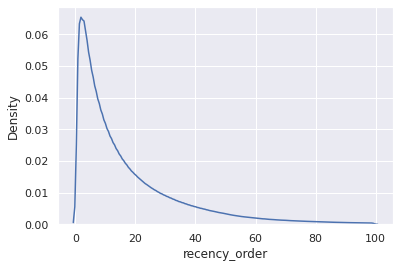

In [ ]:
sns.kdeplot(data=weight_decay,x='recency_order')

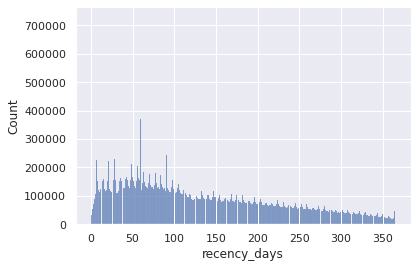

In [ ]:
sns.histplot(data=weight_decay,x='recency_days')

In [ ]:
dataset= pd.read_feather('dataset.feather')

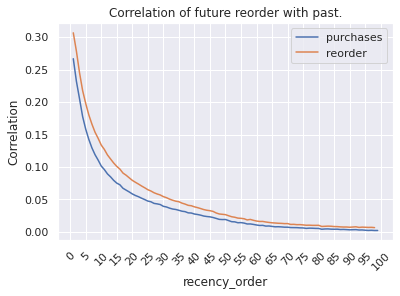

In [ ]:
# How much is the future reorder correlated with the past purcahses and reorders based on orders gap?
recency_list_order = sorted(weight_decay.recency_order.unique())
corr_pur_list_order = []
corr_reord_list_order = [] 
for recency in recency_list_order:
    weight_decay['purchase_weight_order'] = 0
    weight_decay.loc[weight_decay.recency_order==recency,'purchase_weight_order'] = 1
    weight_decay['reorder_weight_order'] = weight_decay['reordered']*weight_decay['purchase_weight_order']
    df = weight_decay.groupby(['user_id','product_id'],as_index=False)[['purchase_weight_order','reorder_weight_order']].sum()
    df = df.merge(dataset[['user_id','product_id','reordered','eval_set']],on=['user_id','product_id'])
    corr_pur = df.loc[df.eval_set=='train','purchase_weight_order'].corr(df.loc[df.eval_set=='train','reordered'],)
    corr_reord = df.loc[df.eval_set=='train','reorder_weight_order'].corr(df.loc[df.eval_set=='train','reordered']) 
    corr_pur_list_order.append(corr_pur)
    corr_reord_list_order.append(corr_reord)
plt.plot(recency_list_order,corr_pur_list_order,label='purchases')
plt.plot(recency_list_order,corr_reord_list_order,label='reorder')
plt.xticks(range(0,101,5),rotation=45)
plt.legend()
plt.xlabel('recency_order')
plt.ylabel('Correlation')
plt.title('Correlation of future reorder with past.')
plt.show()

In [ ]:
# recency_list_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
# corr_pur_list_order = [0.2668280928682746, 0.2320996359047009, 0.20533519910323805, 0.17784803557016762, 0.1582815717892301, 0.14250743777643268, 0.12938585996788177, 0.11893415534767943, 0.11063338568765067, 0.10148809498878711, 0.09603742111872386, 0.0893584321084112, 0.08479597753041299, 0.07939561013364317, 0.07513307011815105, 0.07259068762159572, 0.06720582303314354, 0.06435167161227213, 0.0615597463735406, 0.05847646949135879, 0.056079021430445006, 0.054172706284917924, 0.051869154523953735, 0.04979390979807281, 0.04748601551672607, 0.04638764892567949, 0.04389532342403714, 0.043143762887875636, 0.04213634955169352, 0.039376558422370124, 0.03837843555629439, 0.036568305390431995, 0.035213096699016865, 0.03453184905405174, 0.0332641040158919, 0.0318524072614341, 0.031187922131165773, 0.029321358560369215, 0.02905424303502794, 0.027525927454686638, 0.026788478147750806, 0.025783233118540087, 0.024408275594265224, 0.023676840386840658, 0.023182429789066924, 0.022172647036765237, 0.020763162273343908, 0.019281891909646305, 0.018987578753608726, 0.019097327807029874, 0.017419244794596618, 0.01570025207124487, 0.015445377498246485, 0.014073204512106922, 0.014301540936340078, 0.013551136568874087, 0.01218535619275664, 0.012240835130984208, 0.011514490666757074, 0.010596430316238171, 0.009908497632720475, 0.010044490534652612, 0.008915611862828887, 0.009083377284459121, 0.008449233209849926, 0.007829311715024224, 0.007946232046174494, 0.007660524429064535, 0.0072562712617457665, 0.0072090977749768, 0.006664734250746775, 0.006581956287301868, 0.006517231019061514, 0.006180638471556714, 0.006066642520578219, 0.005385237514731449, 0.0057433201772201905, 0.005632557373660381, 0.005378996388261228, 0.005295994437834474, 0.004054785705020802, 0.004484270448539453, 0.004584310598399934, 0.004196380451318104, 0.004089264567087954, 0.00417192091795145, 0.0036317196628964667, 0.003785855992605996, 0.003505646736574852, 0.0031683482605196975, 0.003357582437114988, 0.0034719975075962147, 0.0028810784112213725, 0.0029890226277359934, 0.002544267088816011, 0.0022462119079982453, 0.0024560778579372205, 0.0021354328866940377, 0.002166716293882253]
# corr_reord_list_order = [0.3067427147489088, 0.2785599337181917, 0.24544978852093893, 0.2178581314734607, 0.1978169085575058, 0.18023475747477125, 0.16601599881019613, 0.15358627159533964, 0.144170378083226, 0.1337574342678048, 0.12705428911317526, 0.11857298412668375, 0.11231134544365488, 0.10614964094196284, 0.10089469194492069, 0.09676221459642743, 0.09063508651607131, 0.0873405659939687, 0.08333160241497026, 0.07941737223598684, 0.07643358522565664, 0.07365817026518065, 0.07066688164637364, 0.06796427817969874, 0.06500143838437102, 0.0629768238302073, 0.06028718426750047, 0.0584102353742034, 0.05688896577675207, 0.05432658378144615, 0.05271665369296893, 0.05049522143946234, 0.04873718689497338, 0.04730396277235254, 0.04647685890209937, 0.04428462578819118, 0.04281016493630424, 0.04091562846318555, 0.04028497997092081, 0.03859673930858013, 0.037386857214298574, 0.03594041916553702, 0.03439236184827929, 0.03330501921323337, 0.0326615622145297, 0.031577921822176315, 0.029161824505014023, 0.027597305148800072, 0.02708740837164394, 0.02656935199252876, 0.024880311264819783, 0.0233327694689947, 0.022546062008007878, 0.02122921311918332, 0.020878631666711542, 0.020222162248754373, 0.018420597985735757, 0.019200923536685593, 0.01783737741726839, 0.016707153238183274, 0.01607068087453255, 0.01610741845178255, 0.015243690306456625, 0.01455799406415641, 0.013991223847165505, 0.013679251537938954, 0.013287977147031163, 0.013118465499127098, 0.012726460085965324, 0.012804216506705806, 0.011501849728250874, 0.011628558476425375, 0.011114419048931179, 0.011194213246901336, 0.010740748182583157, 0.01022893076393762, 0.010341255257856244, 0.010074661700449856, 0.010056382465009603, 0.010126037150471678, 0.008353881855402322, 0.008611459217920735, 0.008872891144602418, 0.008693417953466977, 0.008209474164047085, 0.008136655824496766, 0.007699168063899154, 0.007485157184395367, 0.007505851248734732, 0.007144688073513367, 0.007485176290415874, 0.007829886974671747, 0.006889905879126794, 0.007313423005609981, 0.007106158815509828, 0.006902267461206726, 0.006991982844144218, 0.006593744020375746, np.nan]

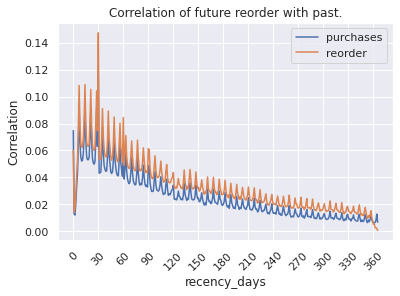

In [ ]:
# How much is the future reorder correlated with the past purcahses and reorders based on days gap?
recency_list_days = sorted(weight_decay.recency_days.unique())
corr_pur_list_days = []
corr_reord_list_days = [] 
for recency in recency_list_days:
    weight_decay['purchase_weight_days'] = 0
    weight_decay.loc[weight_decay.recency_days==recency,'purchase_weight_days'] = 1
    weight_decay['reorder_weight_days'] = weight_decay['reordered']*weight_decay['purchase_weight_days']
    df = weight_decay.groupby(['user_id','product_id'],as_index=False)[['purchase_weight_days','reorder_weight_days']].sum()
    df = df.merge(dataset[['user_id','product_id','reordered','eval_set']],on=['user_id','product_id'])
    corr_pur = df.loc[df.eval_set=='train','purchase_weight_days'].corr(df.loc[df.eval_set=='train','reordered'],)
    corr_reord = df.loc[df.eval_set=='train','reorder_weight_days'].corr(df.loc[df.eval_set=='train','reordered']) 
    corr_pur_list_days.append(corr_pur)
    corr_reord_list_days.append(corr_reord)
plt.plot(recency_list_days,corr_pur_list_days,label='purchases')
plt.plot(recency_list_days,corr_reord_list_days,label='reorder')
plt.xticks(range(0,366,30),rotation=45)
plt.legend()
plt.xlabel('recency_days')
plt.ylabel('Correlation')
plt.title('Correlation of future reorder with past.')
plt.show()

In [ ]:
# recency_list_days = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 235.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 244.0, 245.0, 246.0, 247.0, 248.0, 249.0, 250.0, 251.0, 252.0, 253.0, 254.0, 255.0, 256.0, 257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0, 267.0, 268.0, 269.0, 270.0, 271.0, 272.0, 273.0, 274.0, 275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 287.0, 288.0, 289.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0, 296.0, 297.0, 298.0, 299.0, 300.0, 301.0, 302.0, 303.0, 304.0, 305.0, 306.0, 307.0, 308.0, 309.0, 310.0, 311.0, 312.0, 313.0, 314.0, 315.0, 316.0, 317.0, 318.0, 319.0, 320.0, 321.0, 322.0, 323.0, 324.0, 325.0, 326.0, 327.0, 328.0, 329.0, 330.0, 331.0, 332.0, 333.0, 334.0, 335.0, 336.0, 337.0, 338.0, 339.0, 340.0, 341.0, 342.0, 343.0, 344.0, 345.0, 346.0, 347.0, 348.0, 349.0, 350.0, 351.0, 352.0, 353.0, 354.0, 355.0, 356.0, 357.0, 358.0, 359.0, 360.0, 361.0, 362.0, 363.0, 364.0, 365.0]
# corr_pur_list_days = [0.07477417939802881, 0.012838499006962132, 0.011995686324486844, 0.02080802371167175, 0.032943050033947256, 0.04285524194828235, 0.063229985300334, 0.09471157983166134, 0.06594344299641555, 0.055287092558826495, 0.05216693048193241, 0.05263780769404096, 0.05769809587097678, 0.07056797893271816, 0.09462525155169445, 0.06835774205802286, 0.055364865092710366, 0.05321760920383057, 0.05311808904163172, 0.05484709874199711, 0.06957176715165417, 0.09177945583077055, 0.066441803235502, 0.0540955811597885, 0.050753052911836544, 0.04979837266291414, 0.05193406706966127, 0.06736207160584402, 0.09084502050496848, 0.06306000241288064, 0.11705489230231454, 0.04304858481294807, 0.04345721497342076, 0.04383658179222508, 0.056710711430998255, 0.07756869914079707, 0.05790812857510681, 0.048692093056577866, 0.04600720632865342, 0.04447125310427386, 0.04490173467300842, 0.054838845558262, 0.07506430169794345, 0.05650162979857076, 0.05008117201938431, 0.04391128329870169, 0.04290734705932714, 0.044131547819916066, 0.052205429781274536, 0.07141068856846652, 0.05375139967083085, 0.04693468476943519, 0.043006182675304004, 0.04143103607627174, 0.041099307097221, 0.05233258558425806, 0.06631093134571955, 0.05064095506364101, 0.045269090850783844, 0.04081541244770213, 0.0635425439047195, 0.03874412504400952, 0.04722457803602901, 0.05892669669411567, 0.04463937412662067, 0.03894774793189232, 0.03643207988565956, 0.035331515023077374, 0.03687933048821326, 0.04390760830086672, 0.05466816805982057, 0.04343418356055836, 0.03762502190087446, 0.03546195064494014, 0.034451581457996254, 0.03483815513682465, 0.042018185053716954, 0.05459772698325683, 0.042919372224090556, 0.036376755646290386, 0.03416880977999116, 0.03560747656840961, 0.03466956163369214, 0.039735354128979286, 0.04916386436016204, 0.04045991447633794, 0.03480430587698826, 0.03333689357924597, 0.03432508967354129, 0.03276285115087827, 0.04726273444256414, 0.04882741081214827, 0.0364000955085058, 0.03194198693066191, 0.02957334163938289, 0.029547708230006933, 0.02986678514992945, 0.03720624346492186, 0.044372622382256734, 0.0347007339465863, 0.030930543319288538, 0.030289159008428088, 0.029809953160166873, 0.030881371942702834, 0.03422514554606688, 0.040563058359806656, 0.033357436684052624, 0.029680550990174453, 0.027244262454245948, 0.028046145268403114, 0.02786109175509929, 0.034510172905825705, 0.038696387482421046, 0.031210357262593958, 0.026716828739111596, 0.027875529017923867, 0.027068120132706066, 0.028565819314345053, 0.03048127691190879, 0.03121042628050228, 0.03418852014054558, 0.0239326973268421, 0.023526903854499372, 0.024085553456643222, 0.02332602107778487, 0.025723280048365202, 0.02987002545475792, 0.025961262056989252, 0.02546422775986688, 0.023526046987860063, 0.0238588831698439, 0.023283926442803, 0.02691064979545623, 0.03546787649441534, 0.027807175140552535, 0.025090780855655203, 0.022901917997705655, 0.024429511270568957, 0.023661478099836108, 0.02978004178458194, 0.035922170538063826, 0.029317710905206913, 0.02412161859486356, 0.02337668852328119, 0.023324197061193742, 0.023646041344874233, 0.025900038358084968, 0.03427091869220968, 0.0279548564960103, 0.02423915041298369, 0.024740710693319234, 0.021890864000376473, 0.02217087356399427, 0.024533192694850214, 0.028628293575908594, 0.024070262777052407, 0.021283537969021726, 0.019468503106677987, 0.021009946978189534, 0.01950900084388602, 0.023605455986974718, 0.03128066213998192, 0.0241336870659429, 0.02194497947549048, 0.022214040351662353, 0.02041674035338808, 0.02141396994948803, 0.024411089502724064, 0.031235884788416143, 0.02469519259780998, 0.02139955837119516, 0.02122811119436432, 0.02059558590985866, 0.019987574167104383, 0.023380816943246396, 0.02997131809005197, 0.02391710265102579, 0.02262485546522866, 0.01961871799357132, 0.01928549006544878, 0.02006312424007035, 0.022260593626151456, 0.028672574958668144, 0.0224747488282273, 0.019171350930426236, 0.0179819015107169, 0.01909447253036408, 0.01708587760852612, 0.021883363315701232, 0.02731130299334627, 0.02106539786847047, 0.019364815168533778, 0.017131759144048433, 0.0177894307666799, 0.016754889533245065, 0.02038924342944827, 0.026057512630404338, 0.019942966048741722, 0.018525482835369297, 0.016248490215725605, 0.017605858495703237, 0.016812365442578435, 0.020061355281174514, 0.0239071442624179, 0.019390482250502487, 0.017444245833977638, 0.016976733720036524, 0.016181647757244885, 0.017688668475248567, 0.019298235406137, 0.02493438697815068, 0.019455616588553357, 0.016286798886202533, 0.0161505675967798, 0.015581721910233368, 0.016452194397929356, 0.018448676192670082, 0.024587350548623023, 0.018300617109833914, 0.016327801741451656, 0.016420456122790826, 0.014380666107180418, 0.015179010024185542, 0.017751150582273646, 0.022981375157558798, 0.01767362036299463, 0.014872697481189091, 0.01447100760055844, 0.015349020290683133, 0.015504553411220087, 0.017981530785009667, 0.02022964563384586, 0.015315918916823417, 0.013174340710801369, 0.013688057558471262, 0.012783566520790709, 0.01491044558653455, 0.016416067064462588, 0.020311273776474566, 0.014881475761767177, 0.013347775833719178, 0.01343583383024836, 0.013695000348447162, 0.012779391878826728, 0.015881654209370766, 0.019106762364862816, 0.015435065322556427, 0.012562937467157104, 0.013226567442112, 0.011919632700248563, 0.011810173695063209, 0.014990009672278032, 0.018621740576303957, 0.014801605263696161, 0.012748628064936722, 0.011571799970113802, 0.012441326345046492, 0.012592173241881954, 0.014799613233146701, 0.01911368732857653, 0.012790032979209087, 0.010679180324262827, 0.010597051193532906, 0.01126118567917212, 0.010618958266439561, 0.013111850480441603, 0.01664201530079218, 0.01347408254789228, 0.012885677227185834, 0.01111909705448395, 0.010568467865500801, 0.011368176433971137, 0.013248585656986039, 0.017169143402475343, 0.011257426802363763, 0.010675890296533675, 0.011428438782367408, 0.009664671572639005, 0.011084551333860911, 0.013300090883209553, 0.016182781593526974, 0.010908305291345512, 0.01106078972306578, 0.010777965653947558, 0.010967485778317347, 0.010164653972840693, 0.012560986331659496, 0.016047673420260516, 0.011889008177363693, 0.009525188227514076, 0.010006957309556528, 0.009349034219987363, 0.009563353541921032, 0.012066710727843665, 0.01366335701927808, 0.010848050677687243, 0.008962812151144051, 0.009876968556454726, 0.009259168192581829, 0.010127519920213409, 0.011601764306872903, 0.013207055853815939, 0.010519390071557815, 0.008950353498277146, 0.008744891241804822, 0.009072331454014464, 0.009432377221770863, 0.011346790131745277, 0.01483822014317096, 0.010033766921157034, 0.00979731915624678, 0.010079118666177151, 0.008855357573936361, 0.009353452199530113, 0.011532633604667167, 0.013403867076362498, 0.009889997499551002, 0.009416742845413564, 0.009485502104530174, 0.008606711467006511, 0.008866042634764626, 0.010131144698661432, 0.01379761944632279, 0.009975192717506017, 0.007899856136452672, 0.008050359979379616, 0.009249905390549408, 0.008424928508552889, 0.011642513378729975, 0.012585754781047256, 0.009647473198877933, 0.00877702810112622, 0.008960351743532298, 0.007649800648501012, 0.009381555412971136, 0.009482094312226635, 0.012167857822210955, 0.009229166347035196, 0.00831027019667641, 0.007772566486692045, 0.00763253816220081, 0.007540159779966121, 0.010945529187731081, 0.012557302719331873, 0.009105914287941752, 0.007141469129453388, 0.008407015917771066, 0.007261659017558639, 0.007303085463871877, 0.009147458731363639, 0.012346224313843936, 0.010554993443678792, 0.006930595799704233, 0.006430649472189423, 0.00832970098415285, 0.007150126046949164, 0.008863472790119713, 0.012008245756725298, 0.008557793964771646, 0.007102343847267761, 0.006304219489110503, 0.006326027983628603, 0.006601416611519578, 0.008204573498182415, 0.012709255921007582, 0.006689968406150319]
# corr_reord_list_days = [0.060046349113919206, 0.013909516845813177, 0.017096306298243904, 0.027623668562355843, 0.04138716890334456, 0.05230861481544428, 0.07427049044099446, 0.10829486349978959, 0.077877074485218, 0.06572437705204652, 0.062488486698421976, 0.06245148381319611, 0.06835894559653835, 0.0829342531046079, 0.10891526752333086, 0.08020712325455738, 0.06613695723220415, 0.06341431916254746, 0.06304866184322591, 0.06484153807621408, 0.08097752084661639, 0.10536693240152034, 0.07790832131438308, 0.06465153806258281, 0.060633226279990945, 0.060035495402979276, 0.061942940070286605, 0.07860497412061879, 0.10429902584431351, 0.0747336557580022, 0.14740682111980968, 0.053251686527962805, 0.05337017943868219, 0.053619963504951546, 0.06878961983857994, 0.09113555953150769, 0.07005773501674913, 0.06052428788095948, 0.05654918739820231, 0.05517333295160284, 0.05598028773556749, 0.06665285748575678, 0.0893476981187945, 0.06872203389909516, 0.06165800762822273, 0.05498043690809325, 0.0527262411765629, 0.05501546982732877, 0.06440989189177575, 0.08490210068211027, 0.06571524186230723, 0.05869189908575587, 0.054126724043151046, 0.0516087780257817, 0.05203897676957489, 0.06428616965385243, 0.08025527835834126, 0.06249483746195054, 0.057006055994643694, 0.05116691449751248, 0.08444839299735286, 0.04883500484924458, 0.0585267605516935, 0.07114105812365873, 0.055812312882326624, 0.04960470694349503, 0.04722918641229637, 0.046631985798370586, 0.047943422168900796, 0.05610636525983266, 0.06710362665609194, 0.05515311867075012, 0.04851660057160779, 0.045831242179968146, 0.044863442252851826, 0.045320956672062894, 0.053388163794393026, 0.06769387971438218, 0.054454583455005194, 0.04678514902952838, 0.0447729131580878, 0.04598969111215106, 0.04518666469481101, 0.051086713092947905, 0.06195798823682355, 0.052561984447986015, 0.04566407899814885, 0.04362557790501509, 0.044907483905891665, 0.04319528414104534, 0.061316530726327576, 0.06058687376137726, 0.04703575694068125, 0.04244079145890746, 0.039842792171100934, 0.039036158384998444, 0.039461520964903705, 0.04801169106496673, 0.05604240833011146, 0.045446902141619706, 0.040818866122672895, 0.03988194468797702, 0.040069771347713175, 0.041011499983127364, 0.045148897809365915, 0.052107267179455415, 0.04359689141831363, 0.03978311928254019, 0.03642706635420693, 0.03697066247183476, 0.0371740377958685, 0.044157565430682055, 0.04958312892937717, 0.040383703266675126, 0.03632104131781548, 0.03648333611237014, 0.03587725083493034, 0.03716906298117083, 0.03948657252339833, 0.040286941319547694, 0.043581156755987636, 0.03292407693464447, 0.03177499425999949, 0.03293595907532007, 0.03197515398392774, 0.03493884901243198, 0.03929510602122493, 0.034664011531725346, 0.03429823566748739, 0.03216482613907671, 0.032473694656148806, 0.031399007808576074, 0.0359080712024944, 0.04548161598107524, 0.03655863558600716, 0.03378140198366537, 0.030941950210689215, 0.03323082302314449, 0.03198462033694428, 0.039036488963583985, 0.045850705314190145, 0.038240750136553925, 0.03222405405351515, 0.0313980710269162, 0.03213311701127479, 0.03207941935481459, 0.03478443877316916, 0.04399788829357572, 0.036124065713350376, 0.032040797561288505, 0.032761441097133456, 0.02976042403479148, 0.0303104527697536, 0.03326049706055516, 0.038110417241121484, 0.0331616566609175, 0.030204436328118426, 0.02748605120522639, 0.029065882391672147, 0.028171009121122498, 0.03210195690792091, 0.04033065769142132, 0.03214507544618402, 0.029920701298130407, 0.029656771201795443, 0.02789193903682876, 0.02962453286649992, 0.03229448900406973, 0.04010310556177765, 0.03257699153911544, 0.029057837498988902, 0.029171789492499777, 0.027226276918829923, 0.027716032770937624, 0.030856093370349606, 0.03868031235932774, 0.03203627981516748, 0.030069143962684307, 0.027324806603172314, 0.027155660499205887, 0.027682405640994733, 0.030678763159399963, 0.03786774532843878, 0.030464485428506348, 0.02671047010458849, 0.02547180640673548, 0.026840693894119284, 0.024651528559152945, 0.02963483585550863, 0.03567566958560112, 0.028772974664696315, 0.027223712935147335, 0.024802400317477713, 0.025211692499398825, 0.02392853781492037, 0.02841241867552059, 0.03482351071086681, 0.02799002220450996, 0.026069726769393075, 0.023781590987517597, 0.025563643446804892, 0.023770193059499848, 0.028235051194365195, 0.032526301083197526, 0.0274956223915474, 0.02481599883532101, 0.02385484053675922, 0.023102567543919327, 0.02464397708695305, 0.02684001275440062, 0.03284147265011676, 0.02714772628415762, 0.023188063028365468, 0.02288390046133239, 0.022692025834646082, 0.023534596323952967, 0.026147984686750152, 0.03231309560015959, 0.025754517993296287, 0.02302437913651246, 0.02319988148540371, 0.02084468862757643, 0.02189789095749921, 0.025221104898690203, 0.03094109734415652, 0.024913480312410287, 0.02124659615381797, 0.02141085724818514, 0.0219164856514455, 0.022238259844703966, 0.025209533655629633, 0.027839539969326695, 0.022195772638220646, 0.01959165661302512, 0.020127744374650456, 0.019420301918716434, 0.02166085443989223, 0.023555047197324996, 0.027309579810139737, 0.02226569179564445, 0.0204155381959992, 0.020060350984994205, 0.020338072471499036, 0.01945687796657742, 0.0225894264486889, 0.026123976620639745, 0.022667096695881198, 0.01896995567827765, 0.019337461348804964, 0.01836874673266724, 0.018500456301991434, 0.021471991495969494, 0.026004231584664257, 0.021904732732913587, 0.019103075096270863, 0.01812554677131575, 0.018402731362165123, 0.019095177220175712, 0.021586119015511426, 0.026826077321028298, 0.019992859352091944, 0.01763076945000139, 0.017198468224940974, 0.017624086689779606, 0.017219501747640167, 0.02017365725765858, 0.024720221084558316, 0.02021731070274082, 0.02013902367500724, 0.01776208769074858, 0.017152587482687505, 0.01779289545827254, 0.01988072319740012, 0.025226898723566614, 0.018378326712535867, 0.017639431190506726, 0.01795683230836287, 0.01611680819799137, 0.0173817559985874, 0.019945262739742894, 0.024308023924278194, 0.017385290186049573, 0.017487252564908178, 0.01737606966844009, 0.0173247947496796, 0.016353432298174146, 0.01947255690737367, 0.023853464110292853, 0.018512141609116683, 0.015990491038264044, 0.015828714816236898, 0.01526892865199567, 0.016530821818805445, 0.01906024948536723, 0.021011773731191983, 0.017649451381009925, 0.01487120181718723, 0.015975288203833243, 0.01549561895142045, 0.015953892204073446, 0.01776331800326871, 0.02047581586043587, 0.017306027315147604, 0.014734231236748406, 0.015236811383699539, 0.015043914114357782, 0.015347908681739799, 0.018175471424167224, 0.022498637769834202, 0.016311901092899362, 0.015990659162908028, 0.01585398436565783, 0.014270885753259823, 0.015645309083626404, 0.017530071322240742, 0.020654262059362674, 0.016119674111860598, 0.015779683592144815, 0.014931631425309783, 0.014241562479080698, 0.014003049442001802, 0.01652509634405052, 0.021373108438565117, 0.016496072492446372, 0.013136944958511091, 0.013087706642600156, 0.014414152232048054, 0.014480335043488533, 0.01775208013949009, 0.018439672925583298, 0.015060463629920227, 0.01459533051347272, 0.013639909054719053, 0.0131055450780973, 0.014792876910785789, 0.014948382758580734, 0.018709655640383127, 0.014978995711405579, 0.01382036137067379, 0.013728860013876333, 0.013057891858613781, 0.012645189625207786, 0.01627512716032097, 0.019630451083258917, 0.01495376302103684, 0.012016822512103833, 0.012821205772688552, 0.011995815256145983, 0.011633566844892421, 0.01427525175068178, 0.01780364060874024, 0.014418913701903844, 0.010260388788281838, 0.009732743004436396, 0.011587905708322051, 0.010284590308363116, 0.012070943594847849, 0.015221595011535511, 0.009578408359542689, 0.00797649695051519, 0.00511728639667002, 0.005287076538164462, 0.002644557568100536, 0.0026225930463652345, 0.0019465322180169731, 0.0005544211968337207]

In [ ]:
corr_pur_list_days = dict(zip(recency_list_days,corr_pur_list_days))
corr_pur_list_days

{0.0: 0.07477417939802881,
 1.0: 0.012838499006962132,
 2.0: 0.011995686324486844,
 3.0: 0.02080802371167175,
 4.0: 0.032943050033947256,
 5.0: 0.04285524194828235,
 6.0: 0.063229985300334,
 7.0: 0.09471157983166134,
 8.0: 0.06594344299641555,
 9.0: 0.055287092558826495,
 10.0: 0.05216693048193241,
 11.0: 0.05263780769404096,
 12.0: 0.05769809587097678,
 13.0: 0.07056797893271816,
 14.0: 0.09462525155169445,
 15.0: 0.06835774205802286,
 16.0: 0.055364865092710366,
 17.0: 0.05321760920383057,
 18.0: 0.05311808904163172,
 19.0: 0.05484709874199711,
 20.0: 0.06957176715165417,
 21.0: 0.09177945583077055,
 22.0: 0.066441803235502,
 23.0: 0.0540955811597885,
 24.0: 0.050753052911836544,
 25.0: 0.04979837266291414,
 26.0: 0.05193406706966127,
 27.0: 0.06736207160584402,
 28.0: 0.09084502050496848,
 29.0: 0.06306000241288064,
 30.0: 0.11705489230231454,
 31.0: 0.04304858481294807,
 32.0: 0.04345721497342076,
 33.0: 0.04383658179222508,
 34.0: 0.056710711430998255,
 35.0: 0.07756869914079707,


In [ ]:
corr_reord_list_days = dict(zip(recency_list_days,corr_reord_list_days))
corr_reord_list_days

{0.0: 0.060046349113919206,
 1.0: 0.013909516845813177,
 2.0: 0.017096306298243904,
 3.0: 0.027623668562355843,
 4.0: 0.04138716890334456,
 5.0: 0.05230861481544428,
 6.0: 0.07427049044099446,
 7.0: 0.10829486349978959,
 8.0: 0.077877074485218,
 9.0: 0.06572437705204652,
 10.0: 0.062488486698421976,
 11.0: 0.06245148381319611,
 12.0: 0.06835894559653835,
 13.0: 0.0829342531046079,
 14.0: 0.10891526752333086,
 15.0: 0.08020712325455738,
 16.0: 0.06613695723220415,
 17.0: 0.06341431916254746,
 18.0: 0.06304866184322591,
 19.0: 0.06484153807621408,
 20.0: 0.08097752084661639,
 21.0: 0.10536693240152034,
 22.0: 0.07790832131438308,
 23.0: 0.06465153806258281,
 24.0: 0.060633226279990945,
 25.0: 0.060035495402979276,
 26.0: 0.061942940070286605,
 27.0: 0.07860497412061879,
 28.0: 0.10429902584431351,
 29.0: 0.0747336557580022,
 30.0: 0.14740682111980968,
 31.0: 0.053251686527962805,
 32.0: 0.05337017943868219,
 33.0: 0.053619963504951546,
 34.0: 0.06878961983857994,
 35.0: 0.091135559531507

In [ ]:
corr_reord_list_order = dict(zip(recency_list_order,corr_reord_list_order))
corr_reord_list_order

{1: 0.3067427147489088,
 2: 0.2785599337181917,
 3: 0.24544978852093893,
 4: 0.2178581314734607,
 5: 0.1978169085575058,
 6: 0.18023475747477125,
 7: 0.16601599881019613,
 8: 0.15358627159533964,
 9: 0.144170378083226,
 10: 0.1337574342678048,
 11: 0.12705428911317526,
 12: 0.11857298412668375,
 13: 0.11231134544365488,
 14: 0.10614964094196284,
 15: 0.10089469194492069,
 16: 0.09676221459642743,
 17: 0.09063508651607131,
 18: 0.0873405659939687,
 19: 0.08333160241497026,
 20: 0.07941737223598684,
 21: 0.07643358522565664,
 22: 0.07365817026518065,
 23: 0.07066688164637364,
 24: 0.06796427817969874,
 25: 0.06500143838437102,
 26: 0.0629768238302073,
 27: 0.06028718426750047,
 28: 0.0584102353742034,
 29: 0.05688896577675207,
 30: 0.05432658378144615,
 31: 0.05271665369296893,
 32: 0.05049522143946234,
 33: 0.04873718689497338,
 34: 0.04730396277235254,
 35: 0.04647685890209937,
 36: 0.04428462578819118,
 37: 0.04281016493630424,
 38: 0.04091562846318555,
 39: 0.04028497997092081,
 40: 

In [ ]:
corr_reord_list_order[99] = corr_reord_list_order[98]
corr_pur_list_order = dict(zip(recency_list_order,corr_pur_list_order))
corr_pur_list_order

{1: 0.2668280928682746,
 2: 0.2320996359047009,
 3: 0.20533519910323805,
 4: 0.17784803557016762,
 5: 0.1582815717892301,
 6: 0.14250743777643268,
 7: 0.12938585996788177,
 8: 0.11893415534767943,
 9: 0.11063338568765067,
 10: 0.10148809498878711,
 11: 0.09603742111872386,
 12: 0.0893584321084112,
 13: 0.08479597753041299,
 14: 0.07939561013364317,
 15: 0.07513307011815105,
 16: 0.07259068762159572,
 17: 0.06720582303314354,
 18: 0.06435167161227213,
 19: 0.0615597463735406,
 20: 0.05847646949135879,
 21: 0.056079021430445006,
 22: 0.054172706284917924,
 23: 0.051869154523953735,
 24: 0.04979390979807281,
 25: 0.04748601551672607,
 26: 0.04638764892567949,
 27: 0.04389532342403714,
 28: 0.043143762887875636,
 29: 0.04213634955169352,
 30: 0.039376558422370124,
 31: 0.03837843555629439,
 32: 0.036568305390431995,
 33: 0.035213096699016865,
 34: 0.03453184905405174,
 35: 0.0332641040158919,
 36: 0.0318524072614341,
 37: 0.031187922131165773,
 38: 0.029321358560369215,
 39: 0.029054243035

In [ ]:
# idea: the more the correlation the more should be the weight.
weight_decay['purchase_weight_days_up'] = weight_decay.recency_days.map(corr_pur_list_days)
weight_decay.loc[weight_decay.recency_days<=90,'purchase_weight_days_up'] = 1  # this gives better results(experimentation)

weight_decay['reorder_weight_days_up'] = weight_decay.recency_days.map(corr_reord_list_days)
weight_decay.loc[weight_decay.recency_days<=60,'reorder_weight_days_up'] = 1   # this gives better results(experimentation)
weight_decay['reorder_weight_days_up'] = weight_decay['reorder_weight_days_up'] * weight_decay['reordered']

weight_decay['purchase_weight_order_up'] = weight_decay.recency_order.map(corr_pur_list_order)
weight_decay.loc[weight_decay.recency_order<=7,'purchase_weight_order_up'] = 1  # this gives better results(experimentation)

weight_decay['reorder_weight_order_up'] = weight_decay.recency_order.map(corr_reord_list_order)
weight_decay.loc[weight_decay.recency_order<=5,'reorder_weight_order_up'] = 1   # this gives better results(experimentation)
weight_decay['reorder_weight_order_up'] = weight_decay['reorder_weight_order_up'] * weight_decay['reordered']

In [ ]:
weight_agg = weight_decay.groupby(['user_id','product_id'],as_index=False)\
                [['purchase_weight_days_up','reorder_weight_days_up','purchase_weight_order_up','reorder_weight_order_up']]\
                .sum()
weight_agg.head(3)

,user_id,product_id,purchase_weight_days_up,reorder_weight_days_up,purchase_weight_order_up,reorder_weight_order_up
0,1,196,5.142595,4.214196,7.331056,5.644007
1,1,10258,5.121529,4.175516,7.229568,5.499837
2,1,10326,0.037206,0.000000,1.000000,0.000000


In [ ]:
del weight_decay,df

### Merging features to the dataset.

In [ ]:
del orders,order_products_prior,order_products_train,products,dep,aisles,prior_data

In [ ]:
dataset.shape

(13307953, 50)

In [ ]:
dataset = dataset.merge(future_order_info, on=['order_id','user_id'], how='left')
dataset = dataset.merge(hour_of_day_info, on=['order_hour_of_day'], how='left')
dataset = dataset.merge(dow_info, on=['order_dow'], how='left')
dataset = dataset.merge(order_number_info, on=['order_number'], how='left')
dataset['avg_#reorders_order_number'] = (
    dataset['avg_#reorders_order_number'].fillna(order_number_info['avg_#reorders_order_number'].mean())
)
dataset['p(reorder|order_number)'] = (
    dataset['p(reorder|order_number)'].fillna(order_number_info['p(reorder|order_number)'].mean())
)
dataset = dataset.merge(user_info, on=['user_id'], how='left')
dataset = dataset.merge(days_since_prior_order_info, on=['days_since_prior_order'], how='left')
dataset = dataset.merge(weekly_user, on=['user_id'], how='left')
dataset = dataset.merge(monthly_user, on=['user_id'], how='left')
dataset['is_weekly_user'] = dataset['is_weekly_user'].fillna(value=0).astype('uint8')
dataset['is_monthly_user'] = dataset['is_monthly_user'].fillna(value=0).astype('uint8')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,log_reg_pred,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,avg_#reorders_hour,p(reorder|hour_of_day),avg_#reorders_dow,p(reorder|dow),avg_#reorders_order_number,p(reorder|order_number),#orders_u,avg_#reorders_dspo,p(reorder|dspo),is_weekly_user,is_monthly_user
0,2,13176,1492625,train,0.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.792539,0.802958,0.859117,0.832555,0.000000,0.000000,0,0,0,0.833020,0.553400,0.556994,0.664546,0.777388,0.196390,0.487669,0.311817,0,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0
1,2,41787,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.057738,0.074936,0.167629,0.649903,0.010309,0.076923,0,0,0,0.642270,0.464285,0.528942,0.703155,0.763878,0.312536,0.542696,0.391702,0,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0
2,2,32792,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,0.0668,0.574180,0.043716,0.591986,0.001984,0.002897,0.007816,0.577372,0.082474,0.615385,0,0,1,0.229769,0.288842,0.387333,0.472974,0.282641,0.404285,0.554118,0.494904,1,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0


In [ ]:
del future_order_info,hour_of_day_info,dow_info,user_info,days_since_prior_order_info,weekly_user,monthly_user,order_number_info

In [ ]:
dataset = dataset.merge(prod_lifetime_up, on=['user_id','product_id'], how='left')
dataset = dataset.merge(none_orders_count, on=['user_id'], how='left')
dataset = dataset.merge(user_most_recent_none_order, on=['user_id'], how='left')
dataset = dataset.merge(none_info, on=['user_id'], how='left')
# filling gap of None orders with large values for users who never placed a None order.
dataset['Median_days_gap_none_order_u'] = dataset['Median_days_gap_none_order_u'].fillna(value=9999)
dataset['Max_days_gap_none_order_u'] = dataset['Max_days_gap_none_order_u'].fillna(value=9999)
dataset['Median_orders_gap_none_order_u'] = dataset['Median_orders_gap_none_order_u'].fillna(value=9999)
dataset['Max_orders_gap_none_order_u'] = dataset['Max_orders_gap_none_order_u'].fillna(value=9999)
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,log_reg_pred,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,avg_#reorders_hour,p(reorder|hour_of_day),avg_#reorders_dow,p(reorder|dow),avg_#reorders_order_number,p(reorder|order_number),#orders_u,avg_#reorders_dspo,p(reorder|dspo),is_weekly_user,is_monthly_user,Median_lifetime_days_gap_up,Max_lifetime_days_gap_up,Median_lifetime_orders_gap_up,Max_lifetime_orders_gap_up,#none_orders_u,fraction_none_orders_u,order_number_last_none_order_u,days_since_first_order_last_none_order_u,Median_days_gap_none_order_u,Max_days_gap_none_order_u,Median_orders_gap_none_order_u,Max_orders_gap_none_order_u
0,2,13176,1492625,train,0.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.792539,0.802958,0.859117,0.832555,0.000000,0.000000,0,0,0,0.833020,0.553400,0.556994,0.664546,0.777388,0.196390,0.487669,0.311817,0,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,26.135062,51.80153,2.464184,5.254737,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813
1,2,41787,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.057738,0.074936,0.167629,0.649903,0.010309,0.076923,0,0,0,0.642270,0.464285,0.528942,0.703155,0.763878,0.312536,0.542696,0.391702,0,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,14.000000,14.00000,1.000000,1.000000,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813
2,2,32792,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,0.0668,0.574180,0.043716,0.591986,0.001984,0.002897,0.007816,0.577372,0.082474,0.615385,0,0,1,0.229769,0.288842,0.387333,0.472974,0.282641,0.404285,0.554118,0.494904,1,15,1,11,30.0,228.0,6.405815,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,17.500000,36.00000,1.000000,2.000000,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813


In [ ]:
del prod_lifetime_up,none_orders_count,user_most_recent_none_order,none_info

In [ ]:
dataset = dataset.merge(prod_add_to_cart_order, on=['product_id'], how='left')
dataset = dataset.merge(add_to_cart_order_info,left_on=['median_add_to_cart_order_p'],right_on=['add_to_cart_order'], how='left',)
del dataset['add_to_cart_order']
dataset = dataset.merge(purchase_in_last_3_orders, on=['user_id','product_id'], how='left')
dataset['#purchases_in_last_3_orders_up'] = dataset['#purchases_in_last_3_orders_up'].fillna(value=0)
dataset = dataset.merge(user_base,on=['product_id'], how='left')
dataset = dataset.merge(prod_time,on=['product_id'], how='left')
dataset = dataset.merge(most_recent_purchase_up,on=['user_id','product_id'], how='left')
dataset = dataset.merge(weight_agg,on=['user_id','product_id'], how='left')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,...,p(reorder|hour_of_day),avg_#reorders_dow,p(reorder|dow),avg_#reorders_order_number,p(reorder|order_number),#orders_u,avg_#reorders_dspo,p(reorder|dspo),is_weekly_user,is_monthly_user,Median_lifetime_days_gap_up,Max_lifetime_days_gap_up,Median_lifetime_orders_gap_up,Max_lifetime_orders_gap_up,#none_orders_u,fraction_none_orders_u,order_number_last_none_order_u,days_since_first_order_last_none_order_u,Median_days_gap_none_order_u,Max_days_gap_none_order_u,Median_orders_gap_none_order_u,Max_orders_gap_none_order_u,median_add_to_cart_order_p,p(reorder|add_to_cart_order),#purchases_in_last_3_orders_up,user_base_like_p,user_base_dislike_p,user_base_unknown_p,avg_order_hour_of_day_p,avg_order_dow_p,avg_#reorders_hour_p,p(reorder|hour_of_day)_p,avg_#reorders_dow_p,p(reorder|dow)_p,last_purchase_order_number_up,days_since_first_order_last_purchase_up,purchase_weight_days_up,reorder_weight_days_up,purchase_weight_order_up,reorder_weight_order_up
0,2,13176,1492625,train,0.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.792539,0.802958,0.859117,0.832555,0.000000,0.000000,0,0,...,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,26.135062,51.80153,2.464184,5.254737,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,3.0,0.702757,0.0,45231,18306,142672,13.0,3.0,6.322985,0.620346,5.827394,0.625348,1,0.0,0.015349,0.000000,0.079396,0.000000
1,2,41787,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.057738,0.074936,0.167629,0.649903,0.010309,0.076923,0,0,...,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,14.000000,14.00000,1.000000,1.000000,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,6.0,0.641709,0.0,6146,6252,193811,13.0,3.0,6.322985,0.620346,5.827394,0.625348,7,56.0,0.039690,0.027226,0.229568,0.153586
2,2,32792,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,0.0668,0.574180,0.043716,0.591986,0.001984,0.002897,0.007816,0.577372,0.082474,0.615385,0,0,...,0.626612,6.557553,0.644431,7.07645,0.699321,14,4.568961,0.455603,0,0,17.500000,36.00000,1.000000,2.000000,1,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,7.0,0.626103,1.0,218,361,205630,13.0,3.0,6.322985,0.620346,5.827394,0.625348,12,155.0,1.166038,0.251728,4.494359,2.889635


In [ ]:
del prod_add_to_cart_order,add_to_cart_order_info,purchase_in_last_3_orders,user_base,prod_time,most_recent_purchase_up,weight_agg

In [ ]:
dataset['change_avg_order_hour_of_day_p'] = abs(dataset['order_hour_of_day'] - dataset['avg_order_hour_of_day_p'])
dataset['change_avg_order_dow_p'] = abs(dataset['avg_order_dow_p'] - dataset['avg_order_dow_p'])

# how many orders have been placed after the last None order by user?
dataset['#orders_since_last_none_order_up'] = dataset['order_number']-dataset['order_number_last_none_order_u']
# how many days have passed after the last None order by user?
dataset['days_since_last_none_order_up'] = dataset['days_since_first_order']-dataset['days_since_first_order_last_none_order_u']
dataset['#orders_since_last_none_order_up'] = dataset['#orders_since_last_none_order_up'].fillna(0)
dataset['days_since_last_none_order_up'] = dataset['days_since_last_none_order_up'].fillna(0)

# Has the no. of days since last None order exceeded the Median/Max days gap of None order?
dataset['exceed_in_median_days_gap_none_order_u'] = dataset['days_since_last_none_order_up']-dataset['Median_days_gap_none_order_u']
dataset['exceed_in_max_days_gap_none_order_up'] = dataset['days_since_last_none_order_up']-dataset['Max_days_gap_none_order_u']

# Has the no. of orders since last None order exceeded the Median/Max orders gap of None order?
dataset['exceed_in_median_orders_gap_none_order_u'] = dataset['#orders_since_last_none_order_up']-dataset['Median_orders_gap_none_order_u']
dataset['exceed_in_max_orders_gap_none_order_up'] = dataset['#orders_since_last_none_order_up']-dataset['Max_orders_gap_none_order_u']

In [ ]:
dataset['#reorders_in_last_3_orders_up'] = (
    dataset['reordered_in_last_order'] + dataset['reordered_in_2ndlast_order'] + dataset['reordered_in_3rdlast_order']
)

# how many orders have been placed after the last purchase of the product?
dataset['#orders_since_last_purchase_up'] = dataset['order_number']-dataset['last_purchase_order_number_up']

# How many days have passed after the last purchase of the product?
dataset['days_since_last_purchase_up'] = dataset['days_since_first_order']-dataset['days_since_first_order_last_purchase_up']

# Has the no. of days since last purchase exceeded the lifetime(days gap) of product?
dataset['exceed_in_median_lifetime_days_up'] = dataset['days_since_last_purchase_up']-dataset['Median_lifetime_days_gap_up']
dataset['exceed_in_max_lifetime_days_up'] = dataset['days_since_last_purchase_up']-dataset['Max_lifetime_days_gap_up']

# Has the no. of orders since last purchase exceeded the lifetime(order gap) of product?
dataset['exceed_in_median_lifetime_orders_up'] = dataset['#orders_since_last_purchase_up']-dataset['Median_lifetime_orders_gap_up']
dataset['exceed_in_max_lifetime_orders_up'] = dataset['#orders_since_last_purchase_up']-dataset['Max_lifetime_orders_gap_up']
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,...,fraction_none_orders_u,order_number_last_none_order_u,days_since_first_order_last_none_order_u,Median_days_gap_none_order_u,Max_days_gap_none_order_u,Median_orders_gap_none_order_u,Max_orders_gap_none_order_u,median_add_to_cart_order_p,p(reorder|add_to_cart_order),#purchases_in_last_3_orders_up,user_base_like_p,user_base_dislike_p,user_base_unknown_p,avg_order_hour_of_day_p,avg_order_dow_p,avg_#reorders_hour_p,p(reorder|hour_of_day)_p,avg_#reorders_dow_p,p(reorder|dow)_p,last_purchase_order_number_up,days_since_first_order_last_purchase_up,purchase_weight_days_up,reorder_weight_days_up,purchase_weight_order_up,reorder_weight_order_up,change_avg_order_hour_of_day_p,change_avg_order_dow_p,#orders_since_last_none_order_up,days_since_last_none_order_up,exceed_in_median_days_gap_none_order_u,exceed_in_max_days_gap_none_order_up,exceed_in_median_orders_gap_none_order_u,exceed_in_max_orders_gap_none_order_up,#reorders_in_last_3_orders_up,#orders_since_last_purchase_up,days_since_last_purchase_up,exceed_in_median_lifetime_days_up,exceed_in_max_lifetime_days_up,exceed_in_median_lifetime_orders_up,exceed_in_max_lifetime_orders_up
0,2,13176,1492625,train,0.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.792539,0.802958,0.859117,0.832555,0.000000,0.000000,0,0,...,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,3.0,0.702757,0.0,45231,18306,142672,13.0,3.0,6.322985,0.620346,5.827394,0.625348,1,0.0,0.015349,0.000000,0.079396,0.000000,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,0,14,228.0,201.864938,176.19847,11.535816,8.745263
1,2,41787,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.057738,0.074936,0.167629,0.649903,0.010309,0.076923,0,0,...,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,6.0,0.641709,0.0,6146,6252,193811,13.0,3.0,6.322985,0.620346,5.827394,0.625348,7,56.0,0.039690,0.027226,0.229568,0.153586,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,0,8,172.0,158.000000,158.00000,7.000000,7.000000
2,2,32792,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,0.0668,0.574180,0.043716,0.591986,0.001984,0.002897,0.007816,0.577372,0.082474,0.615385,0,0,...,0.076923,13.0,185.0,44.11773,62.13336,4.381157,6.453813,7.0,0.626103,1.0,218,361,205630,13.0,3.0,6.322985,0.620346,5.827394,0.625348,12,155.0,1.166038,0.251728,4.494359,2.889635,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,1,3,73.0,55.500000,37.00000,2.000000,1.000000


In [ ]:
dataset = dataset.drop(columns=['last_purchase_order_number_up',
                                'days_since_first_order_last_purchase_up',
                                'days_since_first_order_last_none_order_u',
                                'order_number_last_none_order_u',
                                'days_since_first_order',
                                'order_dow',
                                'order_hour_of_day',
                                'avg_order_hour_of_day_p',
                                'avg_order_dow_p',])
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,...,is_monthly_user,Median_lifetime_days_gap_up,Max_lifetime_days_gap_up,Median_lifetime_orders_gap_up,Max_lifetime_orders_gap_up,#none_orders_u,fraction_none_orders_u,Median_days_gap_none_order_u,Max_days_gap_none_order_u,Median_orders_gap_none_order_u,Max_orders_gap_none_order_u,median_add_to_cart_order_p,p(reorder|add_to_cart_order),#purchases_in_last_3_orders_up,user_base_like_p,user_base_dislike_p,user_base_unknown_p,avg_#reorders_hour_p,p(reorder|hour_of_day)_p,avg_#reorders_dow_p,p(reorder|dow)_p,purchase_weight_days_up,reorder_weight_days_up,purchase_weight_order_up,reorder_weight_order_up,change_avg_order_hour_of_day_p,change_avg_order_dow_p,#orders_since_last_none_order_up,days_since_last_none_order_up,exceed_in_median_days_gap_none_order_u,exceed_in_max_days_gap_none_order_up,exceed_in_median_orders_gap_none_order_u,exceed_in_max_orders_gap_none_order_up,#reorders_in_last_3_orders_up,#orders_since_last_purchase_up,days_since_last_purchase_up,exceed_in_median_lifetime_days_up,exceed_in_max_lifetime_days_up,exceed_in_median_lifetime_orders_up,exceed_in_max_lifetime_orders_up
0,2,13176,1492625,train,0.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.792539,0.802958,0.859117,0.832555,0.000000,0.000000,0,0,...,0,26.135062,51.80153,2.464184,5.254737,1,0.076923,44.11773,62.13336,4.381157,6.453813,3.0,0.702757,0.0,45231,18306,142672,6.322985,0.620346,5.827394,0.625348,0.015349,0.000000,0.079396,0.000000,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,0,14,228.0,201.864938,176.19847,11.535816,8.745263
1,2,41787,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,1.0000,0.649913,1.000000,0.718104,0.057738,0.074936,0.167629,0.649903,0.010309,0.076923,0,0,...,0,14.000000,14.00000,1.000000,1.000000,1,0.076923,44.11773,62.13336,4.381157,6.453813,6.0,0.641709,0.0,6146,6252,193811,6.322985,0.620346,5.827394,0.625348,0.039690,0.027226,0.229568,0.153586,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,0,8,172.0,158.000000,158.00000,7.000000,7.000000
2,2,32792,1492625,train,1.0,0.035002,0.062786,0.13931,0.476923,0.153297,0.191489,0.0,0.137255,0.183962,0.1625,0.072727,0.173611,0.144637,0.142857,0.028571,0.097561,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,0.0668,0.574180,0.043716,0.591986,0.001984,0.002897,0.007816,0.577372,0.082474,0.615385,0,0,...,0,17.500000,36.00000,1.000000,2.000000,1,0.076923,44.11773,62.13336,4.381157,6.453813,7.0,0.626103,1.0,218,361,205630,6.322985,0.620346,5.827394,0.625348,1.166038,0.251728,4.494359,2.889635,2.0,0.0,2.0,43.0,-1.11773,-19.13336,-2.381157,-4.453813,1,3,73.0,55.500000,37.00000,2.000000,1.000000


In [ ]:
dataset.to_feather('dataset.feather')

In [ ]:
kaggle_file_uploader(['./dataset.feather'],
                     msg='Full Dataset.',)

Data package template written to: data/dataset-metadata.json
Starting upload for file dataset.feather
100% 2.01G/2.01G [00:30<00:00, 71.0MB/s]
Upload successful: dataset.feather (2GB)
Dataset version is being created. Please check progress at /api/v1/datasets/status/shubhamscifi/instacart


In [ ]:
dataset.shape

(13307953, 102)

In [ ]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Columns: 102 entries, user_id to exceed_in_max_lifetime_orders_up
dtypes: category(1), float16(3), float32(8), float64(72), int64(3), uint16(1), uint32(2), uint8(12)
memory usage: 8.2 GB


In [ ]:
ftrs = list(dataset.columns[5:49]) + list(dataset.columns[50:]) # 49th idx is log-reg prediction
print("No. of features in data:",len(ftrs))

No. of features in data: 96




---

